In [129]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

# Problem Statement

We work with adjusted close prices of financial assets.  
One asset is selected as the **target series**, while the others serve as **donor series**.  

The challenge:  
- The target series contains missing values (NaNs).  
- We want to **impute these missing values** as accurately as possible.  
- Donor series may also contain NaNs, which we handle appropriately during preprocessing.  

The goal:   
- Achieve better accuracy than simple linear interpolation.  


# Part 0: data preparation


In this section we load the historical price series, artificially generate missing values 
(NaNs), and prepare "donor" series that will be used as predictors for imputation.

The donors are auxiliary time series (other assets or related instruments) that 
can help predict the missing values of the target series.

In [131]:
start_date = '2020-01-01'
end_date = '2025-01-01'

In [132]:
import pandas as pd
sp500_tickers = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]['Symbol'].to_list()

In [133]:
sp500_tickers = [name for name in sp500_tickers if '.B' not in name]

In [134]:
historical_prices = yf.download(sp500_tickers, start = start_date, end = end_date, auto_adjust = False)

[*********************100%***********************]  501 of 501 completed

1 Failed download:
['PRU']: Timeout('Failed to perform, curl: (28) Connection timed out after 10011 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


In [135]:
historical_prices = historical_prices.loc[:, historical_prices.columns.get_level_values(0) == 'Adj Close']
historical_prices.columns = historical_prices.columns.droplevel(0)

In [136]:
ticker_counts = historical_prices.count()

In [137]:
MIN_REQ_NUM = 100
valid_tickers_mask = ticker_counts[ticker_counts >= MIN_REQ_NUM ].index
historical_prices = historical_prices[valid_tickers_mask]

In [138]:
target_ticker = 'AAPL'

In [294]:
sum(historical_prices[target_ticker].isna())

0

looks like there is no nans in AAPL. well, let us introduce them by hands.

In [295]:
def generate_nans(p, df):
    mask = np.random.rand(*df.shape) < p
    return df.mask(mask)

In [296]:
historical_prices_with_nans = generate_nans(0.01, historical_prices)

In [297]:
def give_donors(K, df, target_ticker):
    f_returns = np.log(df).diff()[1:]
    corr = np.abs(f_returns.head().corr()[target_ticker]).sort_values(ascending=False)   
    
    corr_topK = corr[1:K+1]
    most_corr_index = corr_topK.index.to_list()
    mask = f_returns[most_corr_index].isna().sum(axis=1).gt(1)
    donors = np.log(historical_prices_with_nans[most_corr_index].interpolate(method="linear", limit_direction="both")).diff()

    return donors

In [298]:
donors = give_donors(15, historical_prices_with_nans, target_ticker)
s = historical_prices_with_nans[target_ticker].copy()

# Part 1: fitting single nans

For imputing **single missing values** in the target series, we want to use:

- The previous value (yesterday).  
- The next value (tomorrow).  
- The donor series (related assets).  

However, the donors may be on very different scales. Simply applying a scaler (e.g., standardization) is not enough, because one of the donors may have a strong **exponential trend**.  

To address this, we transform the **donors** into **log returns**. This makes all donor series approximately scale-invariant and comparable.

For the **target series** we cannot directly switch to log returns, because every missing value in prices would create two missing values in returns. Instead, we handle it differently:

- We linearly interpolate the missing values in the target price series.  
- The model is then trained to predict the **relative deviation** between the true price and its linear interpolation.  

This way:  
- All donor data are on a comparable scale (log returns).  
- The target is defined as a relative correction to linear interpolation.  
- The model learns to improve upon interpolation rather than predicting absolute values.

## Feature Construction and Target Definition

Here we construct the training features and target values for the model.

- **Features (X):** donor time series and their one-step shifts.  
- **Target (y):** relative correction of the target series compared to a simple 
  linear interpolation between neighbors.  

We train only on points where both left and right neighbors are available 
(no NaNs on either side).

In [299]:
def give_train_target(s, donors):
    # Training indices: valid points with valid left and right neighbors
    mask_train = (
        s.notna() &
        s.shift(1).notna() &
        s.shift(-1).notna()
    )
    train_indices = s.index[mask_train].tolist()
    
    # Target indices: missing points with valid neighbors on both sides
    mask_target = (
        s.isna() &
        s.shift(1).notna() &
        s.shift(-1).notna()
    )
    target_indices = s.index[mask_target].tolist()
    
    # Linear interpolation (average of neighbors)
    lin = (s.shift(1) + s.shift(-1)) / 2
    
    # Target values: relative correction with respect to interpolation
    y = ((s - lin) / lin).loc[train_indices].to_numpy()
    
    # Features: donors and their forward shift
    X = pd.concat(
        [donors, donors.shift(-1)], axis=1
    ).loc[train_indices].to_numpy()
    
    # Remove edges where shift produced NaN
    X, y = X[1:-1], y[1:-1]
    
    # Features for target indices (values to impute)
    X_target = pd.concat(
        [donors, donors.shift(-1)], axis=1
    ).loc[target_indices].to_numpy()
    
    return X, y, X_target, target_indices

In [300]:
X, y, X_target, target_indices = give_train_target(s, donors)

### Searching for beat ElasticNet params

In [301]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import ParameterSampler
from tqdm import tqdm

param_grid = {
    "alpha": np.logspace(-4, 2, 200),          
    "l1_ratio": np.linspace(0.1, 0.9, 200)      
}

sampler = list(ParameterSampler(param_grid, n_iter=400, random_state=42))


kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_score = float('inf')
best_params = None
results = []

for params in tqdm(sampler, desc="Random search ElasticNet"):
    cv_scores = []
    for train_idx, val_idx in kf.split(X):
        
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]

        preds_val = np.zeros_like(y_val, dtype=float)
        
        model = ElasticNet(**params)
        
        model.fit(X_train, y_train)
        pred = model.predict(X_val)
        cv_scores += [mean_squared_error(y_val, pred)**0.5]
    
    mean_cv_score = np.mean(cv_scores)
    results.append((mean_cv_score, params))
    if mean_cv_score < best_score:
            best_score = mean_cv_score
            best_params = params

   
print(f"Best params: {best_params}, LogLoss: {best_score:.4f}")

    



Random search ElasticNet: 100%|█████████████████████████████████████████████████████| 400/400 [00:02<00:00, 143.24it/s]

Best params: {'l1_ratio': np.float64(0.12412060301507538), 'alpha': np.float64(0.00010718913192051276)}, LogLoss: 0.0093


In [302]:
model = ElasticNet(**best_params)
pred = model.fit(X, y)

pred = model.predict(X_target)

In [303]:
lin = (s.shift(1) + s.shift(-1)) / 2

In [304]:
lin.loc[target_indices].values

array([119.41989136, 129.24633789, 163.34687805, 151.54399109,
       150.8143158 , 162.91918945, 185.69782257, 165.25327301,
       166.23622131, 207.701828  ])

In [305]:


# price reconstraction
pred_prices = (1 + pred) * lin.loc[target_indices].values


In [306]:

true_prices = historical_prices[target_ticker].loc[target_indices].values

easy_pred_prices = historical_prices_with_nans[target_ticker].interpolate().loc[target_indices].values

In [307]:
mean_squared_error(pred_prices, true_prices)**0.5

1.0449586617079996

In [308]:
mean_squared_error(easy_pred_prices, true_prices)**0.5

1.0489175574071563

In [309]:
aver = 100
p_arr = np.linspace(0.005, 0.1, 25)
performance = np.zeros(len(p_arr))

for i in tqdm(range(len(p_arr))):
    p = p_arr[i]
    for j in range(aver):
   
        historical_prices_with_nans = generate_nans(p, historical_prices)
        donors = give_donors(15, historical_prices_with_nans, target_ticker)
        s = historical_prices_with_nans[target_ticker]
        X, y, X_target, target_indices = give_train_target(s, donors)
    
        model = ElasticNet(**best_params)
        pred = model.fit(X, y)
        
        pred = model.predict(X_target)

        lin = (s.shift(1) + s.shift(-1)) / 2
        pred_prices = (1 + pred) * lin.loc[target_indices].values

        true_prices = historical_prices[target_ticker].loc[target_indices].values

        easy_pred_prices = historical_prices_with_nans[target_ticker].interpolate().loc[target_indices].values

        s1 = mean_squared_error(pred_prices, true_prices)**0.5
        s2 = mean_squared_error(easy_pred_prices, true_prices)**0.5
        performance[i] += (s2-s1)/s2 / aver

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:43<00:00,  8.94s/it]


C:\Users\Костя\AppData\Local\Temp\ipykernel_3076\475930803.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize =17)


Text(0.5, 0, 'Nan probability')

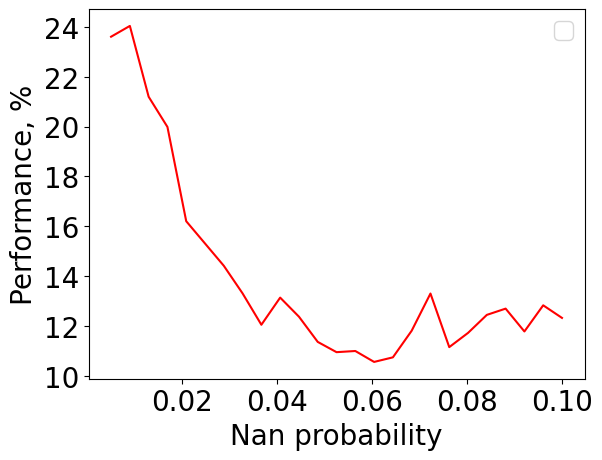

In [310]:
plt.plot(p_arr, performance*100, c ='r')

plt.xticks(fontsize =20)
plt.yticks(fontsize = 20)


plt.ylabel("Performance, %", fontsize =20)
#plt.title('$k_{minloss} = \\pi/4$', fontsize = 20)
plt.legend(fontsize =17)
plt.xlabel("Nan probability", fontsize = 20)

### Our method achieves about 24% improvement over simple linear interpolation when imputing single missing values — a strong result.

# Part 2: fitting all nans, not only single ones

We first train the model on the "linear" regime (points with both neighbors available).  
Then, we iteratively fill missing values:

1. **Forward regime:** train using the next neighbor (shift -1).  
2. **Backward regime:** train using the previous neighbor (shift +1).  

At each step, we predict missing values and update the series, until no NaNs remain.

In [291]:
def give_train_target(s, donors, regime='linear'):
    if regime == 'linear':
        # Training indices: valid values with valid neighbors on both sides
        mask_train = s.notna() & s.shift(1).notna() & s.shift(-1).notna()
        train_indices = s.index[mask_train].tolist()

        # Target indices: missing values with valid neighbors on both sides
        mask_target = s.isna() & s.shift(1).notna() & s.shift(-1).notna()
        target_indices = s.index[mask_target].tolist()

        interpol = (s.shift(1) + s.shift(-1)) / 2

        X = pd.concat([donors, donors.shift(-1)], axis=1).loc[train_indices].to_numpy()
        X_target = pd.concat([donors, donors.shift(-1)], axis=1).loc[target_indices].to_numpy()

    elif regime == 'forward':
        # Training indices: valid values with valid right neighbor
        mask_train = s.notna() & s.shift(-1).notna()
        train_indices = s.index[mask_train].tolist()

        # Target indices: missing values with valid right neighbor
        mask_target = s.isna() & s.shift(-1).notna()
        target_indices = s.index[mask_target].tolist()

        interpol = s.shift(-1)

        X = pd.concat([donors, donors.shift(-1)], axis=1).loc[train_indices].to_numpy()
        X_target = pd.concat([donors, donors.shift(-1)], axis=1).loc[target_indices].to_numpy()

    elif regime == 'backward':
        # Training indices: valid values with valid left neighbor
        mask_train = s.notna() & s.shift(1).notna()
        train_indices = s.index[mask_train].tolist()

        # Target indices: missing values with valid left neighbor
        mask_target = s.isna() & s.shift(1).notna()
        target_indices = s.index[mask_target].tolist()

        interpol = s.shift(1)

        X = pd.concat([donors, donors.shift(1)], axis=1).loc[train_indices].to_numpy()
        X_target = pd.concat([donors, donors.shift(1)], axis=1).loc[target_indices].to_numpy()

    else:
        raise ValueError("Unknown regime")

    # Target values as relative deviation from interpolation
    y = ((s - interpol) / interpol).loc[train_indices].to_numpy()

    # Remove edges where shift produced NaN
    X, y = X[1:-1], y[1:-1]

    return X, y, X_target, target_indices, interpol


In [292]:
aver = 100
p_arr = np.linspace(0.005, 0.3, 20)
performance = np.zeros(len(p_arr))

for i, p in tqdm(enumerate(p_arr), total=len(p_arr)):
    for j in range(aver):
        # Containers for predictions and ground truth
        pred_prices = []
        true_prices = []
        easy_pred_prices = []
        
        # Generate missing values
        historical_prices_with_nans = generate_nans(p, historical_prices)
        
        # Donors with interpolation
        donors = give_donors(15, historical_prices_with_nans, target_ticker).interpolate(
            method="linear", limit_direction="both"
        )
        
        # Target series with missing values
        s = historical_prices_with_nans[target_ticker].copy()
        
        # Simple baseline prediction (linear interpolation)
        easy_predict = s.interpolate(method="linear", limit_direction="both")
        
        # Initial training on "linear" regime
        X, y, X_target, target_indices, interpol = give_train_target(s, donors)
        
        
        model = ElasticNet(**best_params)
        model.fit(X, y)
            
        pred = model.predict(X_target)
        pred_prices_t = (1 + pred) * interpol.loc[target_indices].values
        s[target_indices] = pred_prices_t
            
            # Collect results
        pred_prices = np.hstack((pred_prices, pred_prices_t))
        true_prices = np.hstack((true_prices, historical_prices[target_ticker].loc[target_indices].values))
        easy_pred_prices = np.hstack((easy_pred_prices, easy_predict.loc[target_indices].values))
    
            # Iteratively fill gaps using forward/backward regimes
        X, y, X_target, target_indices, interpol = give_train_target(s, donors, regime="forward")
        
        while len(X_target) > 0:
            # Forward step
            model = ElasticNet(**best_params)
            model.fit(X, y)
            
            pred = model.predict(X_target)
            pred_prices_t = (1 + pred) * interpol.loc[target_indices].values
            s[target_indices] = pred_prices_t
            
            pred_prices = np.hstack((pred_prices, pred_prices_t))
            true_prices = np.hstack((true_prices, historical_prices[target_ticker].loc[target_indices].values))
            easy_pred_prices = np.hstack((easy_pred_prices, easy_predict.loc[target_indices].values))
            
            # Backward step
            X, y, X_target, target_indices, interpol = give_train_target(s, donors, regime="backward")
            
            if len(X_target) > 0:
                model = ElasticNet(**best_params)
                model.fit(X, y)
                
                pred = model.predict(X_target)
                pred_prices_t = (1 + pred) * interpol.loc[target_indices].values
                s[target_indices] = pred_prices_t
                
                pred_prices = np.hstack((pred_prices, pred_prices_t))
                true_prices = np.hstack((true_prices, historical_prices[target_ticker].loc[target_indices].values))
                easy_pred_prices = np.hstack((easy_pred_prices, easy_predict.loc[target_indices].values))
                
                # Switch back to forward regime
                X, y, X_target, target_indices, interpol = give_train_target(s, donors, regime="forward")

        # Compute RMSE for model vs baseline
        rmse_model = mean_squared_error(pred_prices, true_prices) ** 0.5
        rmse_baseline = mean_squared_error(easy_pred_prices, true_prices) ** 0.5
        
        # Normalized improvement
        performance[i] += (rmse_baseline - rmse_model) / rmse_baseline / aver

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [04:18<00:00, 12.94s/it]


C:\Users\Костя\AppData\Local\Temp\ipykernel_3076\2558559607.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize =17)


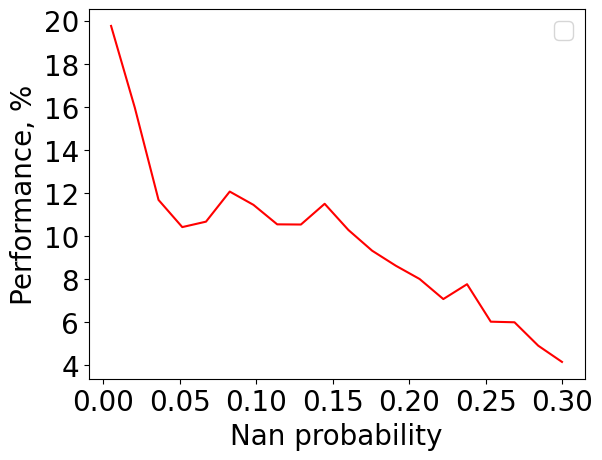

In [293]:
plt.plot(p_arr, performance*100, c ='r')

plt.xticks(fontsize =20)
plt.yticks(fontsize = 20)


plt.ylabel("Performance, %", fontsize =20)
#plt.title('$k_{minloss} = \\pi/4$', fontsize = 20)
plt.legend(fontsize =17)
plt.xlabel("Nan probability", fontsize = 20)
plt.savefig("plot.png", dpi=300, bbox_inches="tight")